In [97]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class BaskinRobins31:
    def __init__(self, verbose=False):
        self.number = 0
        self.verbose = verbose
        self.is_gameover = False

    def move(self, action):
        before_number = self.number
        self.number = min(30, self.number+action)
        if self.verbose: print("나: {}".format([i for i in range(before_number+1, self.number+1)]))

    def opponent_move(self, action):
        if self.number == 30:
            self.number = 31
            if self.verbose: print("상대: [31] \n당신이 이겼습니다!")
            self.is_gameover = True
            return 10
        else:
            before_number = self.number
            self.number = min(30, self.number+action)
            if self.number == 30:
                if self.verbose: print("상대: {} \n당신이 졌습니다.".format([i for i in range(before_number+1, self.number+1)]))
                self.is_gameover = False
                return -10
            else:
                if self.verbose: print("상대: {}".format([i for i in range(before_number+1, self.number+1)]))
                return 0

    def select_opponent_move(self, action_type="best"):
        if action_type == "best":  # 최선의 수를 선택
            if (self.number+2)%4 == 0:
                return self.opponent_move(random.randint(1, 3))
            else:
                return self.opponent_move(4 - (self.number+2)%4)
        elif action_type == "random":  # 동등한 확률로 랜덤하게 선택
            return self.opponent_move(random.randint(1, 3))
        else:
            print("action_type은 'best'이거나 'random'이어야 합니다.")

    def reset(self):
        self.number = 0
        is_gameover = False

In [3]:
game = BaskinRobins31(verbose=True)
print("현재 진행 수:", game.number) # 0 -> 출력
# 현재 진행 수를 불러옵니다, 다음으로 말할 수는 1을 뜻합니다.

현재 진행 수: 0


In [4]:
game.move(3)
print("현재 진행 수:", game.number) # 3 -> 출력

game.opponent_move(1)
print("현재 진행 수:", game.number) # 5-> 출력

나: [1, 2, 3]
현재 진행 수: 3
상대: [4]
현재 진행 수: 4


In [5]:
# move메서드와 opponent_move메서드는 한 세트입니다. 나의 action이 이루어지고 나서,
# 상대방의 action이 이루어지고 이 때 승패(reward)를 결정합니다.
game.move(1)
reward = game.select_opponent_move("best")
print("현재 진행 수:", game.number) # 6 -> 출력

나: [5]
상대: [6]
현재 진행 수: 6


In [6]:
game.number = 28 # 특정 state로 이동시킬 수 있습니다.
game.move(2)
reward = game.select_opponent_move("best")
print("해당 움직임의 보상:", reward) # 10 -> 출력

# 내가 30을 말하게 되면 이기게 되어있습니다.

나: [29, 30]
상대: [31] 
당신이 이겼습니다!
해당 움직임의 보상: 10


In [7]:
# 질 때의 경우입니다. 상대가 30을 말하게 되면 패배합니다.
game.number = 26
game.move(1)
reward = game.select_opponent_move("best")
print("해당 움직임의 보상:", reward) # -10 -> 출력

나: [27]
상대: [28, 29, 30] 
당신이 졌습니다.
해당 움직임의 보상: -10


In [112]:
class player:
    def __init__(self):
        self.v_table = np.zeros(31)  # 0~30까지의 state를 가집니다.
        self.p = 1/3
        self.alpha = 0.1  # 학습률
        self.gamma = 0.3  # 할인율
    def policy_evaluation(self, game, policy, iter_num):
        next_v_table = np.zeros(31)
        for _ in range(iter_num):
            next_v_table = np.zeros(31)
            for state in range(31):
                game.number = state
                reward = game.select_opponent_move("best")
                value_t = 0
                for act in range(1, 4):
                    if state+act > 30:
                        value = policy[state][act-1]*(reward+self.gamma*self.v_table[30])
                        value_t += value
                    else:
                        value = policy[state][act-1]*(reward+self.gamma*self.v_table[state+act])
                        value_t += value
                next_v_table[state] = value_t
            self.v_table = next_v_table
        return next_v_table
        
    def policy_improvement(self, game, policy):
        available_action = [1, 2, 3]
        
        #get q func
        q_table = np.zeros([31, 3])
        for state in range(31):
            game.number = state
            for act in available_action:
                reward = game.opponent_move(act)
                if state+act > 30:
                    q_table[state, act-1] = self.p*(reward+self.gamma*self.v_table[30])
                else:
                    q_table[state, act-1] = self.p*(reward+self.gamma*self.v_table[state+act])
        #get greedy policy
        for state in range(31):
            greedy_action = np.argmax(q_table[state])
            policy[state] = greedy_action
        return policy


[-4101.43252468 -6009.85343111 -3107.76346174 -4553.82485607
 -2354.83406737 -3450.5526157  -1784.32141038 -2614.57286514
 -1352.02675065 -1981.13841882 -1024.45627243 -1501.16114427
  -776.279948   -1137.41314917  -588.24214327  -861.94453421
  -445.50190448  -653.36070556  -337.71161364  -493.93402906
  -257.28886656  -374.4824832   -191.452032    -291.69504
  -140.9904      -205.488       -139.68        -124.8
   -78.           -30.             0.        ]


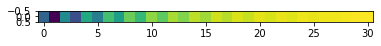

In [113]:
game1 = BaskinRobins31()
player1 = player()
policy = np.ones([31,3])/3
for i in range(100):
    for act in range(1, 4):
        player1.policy_evaluation(game1, policy, 100)
    policy = player1.policy_improvement(game1, policy)
print(player1.v_table)
plt.imshow(np.reshape(player1.v_table, (1, 31)))





